In [1]:
from torch.utils.data import Dataset
import torch
import os
from torchvision.io import read_image
from PIL import Image
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import albumentations as A
import cv2
from torch.nn import functional as F

class SmileDataset(Dataset):
    def __init__(self, data_dir,transform=None):
        self.label_name = {"no": 0, "yes": 1}
        # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
        self.data_info = self.get_img_info(data_dir)  
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')
        # 调整尺寸
        img = img.resize((224, 128))
        img_array = np.array(img)
        if self.transform is not None:
            transformed = transform(image=img_array)
            img = transformed['image']
#         # 标准化
#         mean = np.mean(img)
#         std_dev = np.std(img)
#         img = (img - mean) / std_dev
#         # 调整通道
#         img = np.transpose(img, (2, 0, 1)) 
        label = torch.from_numpy(np.array(label))
        return img, label

    def __len__(self):
        return len(self.data_info)

    def get_img_info(self,data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # 遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = sub_dir
                    data_info.append((path_img, int(label)))

        return data_info

In [2]:
# 数据的路径
split_dir = './pics_no_yse2/'
train_dir = os.path.join(split_dir, 'train/')
valid_dir = os.path.join(split_dir, 'val/')

# 定义图像增强流水线
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  #水平翻转
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=15, p=0.5),   # 平移、缩放和旋转
    ToTensorV2()
#     A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),  # 锐化操作
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),    # 颜色抖动
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
BATCH_SIZE = 8
## 构建MyDataset实例
train_data = SmileDataset(data_dir=train_dir, transform=transform)
valid_data = SmileDataset(data_dir=valid_dir, transform=transform)

# 构建DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
def convertimg(img,channel):
    if channel ==3:
        img = np.transpose(img.numpy(),(1,2,0))
    else:
        img = np.squeeze(img.numpy())
    return img

torch.Size([8, 3, 128, 224]) torch.Size([8])


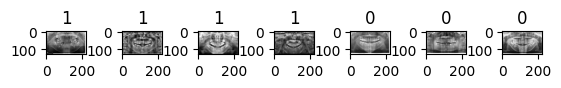

In [4]:
image,label = next(iter(train_loader))
print(image.shape,label.shape)
label = label.numpy()
for i in range(7):
    temp = i+1
    plt.subplot(1,7,temp)
    plt.imshow(convertimg(image[temp],3))
    plt.title(label[temp]) 
    plt.subplots_adjust(wspace=0.9, hspace=0.8)
plt.show()

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, num_classes=3, size_average=True):
        super(FocalLoss, self).__init__()
        self.size_average = size_average
        if alpha is None:
            self.alpha = torch.ones(num_classes)
        elif isinstance(alpha, list):
            assert len(alpha) == num_classes
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha < 1
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] = alpha
            self.alpha[1:] = 1 - alpha

        self.gamma = gamma
        print('Focal Loss:')
        print('    Alpha = {}'.format(self.alpha))
        print('    Gamma = {}'.format(self.gamma))

    def forward(self, preds, labels):
        if preds.device != self.alpha.device:
            self.alpha = self.alpha.to(preds.device)

        # 使用log_softmax避免数值溢出
        log_probs = F.log_softmax(preds, dim=-1)
        probs = torch.exp(log_probs)
        
        # 选择标签对应的预测概率
        labels = labels.view(-1)
        probs = probs.gather(dim=1, index=labels.unsqueeze(1)).squeeze(1)
        log_probs = log_probs.gather(dim=1, index=labels.unsqueeze(1)).squeeze(1)
        alpha = self.alpha[labels]

        # 计算Focal Loss
        focal_weight = torch.pow(1 - probs, self.gamma)
        loss = -alpha * focal_weight * log_probs

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [6]:
def adjust_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
# 获取当前的学习率
def get_current_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [7]:
from tqdm import *
from torch.optim.lr_scheduler import StepLR
from torch import optim

def train_net(model, train_data, val_data, model_dir, batch=32, epochs=50, lr=1e-3):
    print("training the network...")
    #2、定义trainLoader 和 ValLoader
    train_loader  = DataLoader(train_data,batch_size=batch,shuffle=True)
    # 损失函数和优化器
    loss_func = nn.CrossEntropyLoss()
    
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#     opt = optim.SGD(model.parameters(),lr=lr, momentum=0.9)
    train_size = len(train_loader)
    best_acc = 0
    model.train()
    # 开始训练
    for t in tqdm(range(epochs)):
        train_correct,train_loss = 0,0
        for inputs,outputs in train_loader:
            input_size = len(train_loader)
            inputs,outputs = inputs.to(device).float(),outputs.to(device).long()
            opt.zero_grad()
            pred = model(inputs)
            pred_classes = pred.argmax(dim=1)
            loss = loss_func(pred,outputs)
            # 反向传播
            loss.backward()
            opt.step()
#             # softmax激活为概率分布
#             pred = nn.functional.softmax(pred, dim=1)
            # 记录训练过程
            train_acc = ((pred_classes == outputs).type(torch.float).sum().item())/len(inputs)
            train_correct += train_acc
            train_loss += loss.cpu().float()
        # 获取当前学习率
        current_lr = get_current_learning_rate(opt)
        current_acc = train_correct / len(train_loader)
        current_loss = train_loss.item() / len(train_loader)
        print("epoch: {}/{}==== train_acc: {:<10.6f} train_loss: {:<10.6f} Current_lr: {:<10.6f}".format(
                    t, epochs, current_acc, current_loss, current_lr))
        # 更新学习率
        if ((t+1)%20==0) and (current_lr>0.00001):
            new_lr = current_lr*0.1  # 新的学习率
            adjust_learning_rate(opt, new_lr)
            print('Epoch:', t, 'NEW_LR:', new_lr)
        test_process(model,64,val_data, loss_func)
         
        # 保存权重
        save_path = os.path.join('./',model_dir)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if current_acc > best_acc:
            MODEL_PATH = os.path.join(model_dir, 'Model_epoch%{}.pth'.format(t+1))
            torch.save(model, MODEL_PATH)
            best_acc = current_acc

def test_process(model,batchsize,test_data, loss_Function):
    # 1、初始化损失函数、优化器、学习率策略等
    model.eval()
    test_loader = DataLoader(test_data,batch_size=batchsize)
    TestAcc = []
    TestLoss = []
    with torch.no_grad():
        for inputs, outputs in test_loader:
            inputs, outputs = inputs.to(device).float(), outputs.to(device).long()
            # 计算损失
            pred = model(inputs)
            loss = loss_Function(pred,outputs)
            # softmax激活为概率分布
            pred = nn.functional.softmax(pred, dim=1)
            pred_classes = pred.argmax(dim=1)
            # 计算ACC
            train_acc = ((pred_classes == outputs).type(torch.float).sum().item())/ len(inputs)
            TestAcc.append(train_acc)
            TestLoss.append(loss)
    avgTestLoss = torch.mean(torch.stack(TestLoss))
    avgTestAcc = sum(TestAcc) / len(TestAcc)
    print("testing loss is {:.5f},testing Acc is {:.5f}".format(avgTestLoss,avgTestAcc))

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练的 VGG16 模型
vgg16 = models.vgg16(pretrained=True)

# state_dict = torch.load('./vgg16.pth')
# Remove keys from state_dict that belong to the fully connected layers
# for key in list(state_dict.keys()):
#     if key.startswith('classifier'):
#         del state_dict[key]
# vgg16.load_state_dict(state_dict, strict=False)

# 1. 清空分类层
vgg16.classifier = nn.Sequential()

# num_classes 为你的分类数
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(True),
    nn.Dropout(p=0.1),
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Dropout(p=0.1),
    nn.Linear(1024, 2)
)

# # 3. 冻结预训练模型的参数，只训练新添加的分类层
# for param in vgg16.parameters():
#     param.requires_grad = False

# # 可选：解冻最后几层以进行微调
# for param in vgg16.features[-6:].parameters():
#     param.requires_grad = True

# 将模型移动到设备（GPU 或 CPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
train_path = './pics_no_yse2/train'
val_path = './pics_no_yse2/val'

transform = A.Compose([
    A.HorizontalFlip(p=0.5),  #水平翻转
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=15, p=0.5),   # 平移、缩放和旋转
#     A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),  # 锐化操作
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),    # 颜色抖动
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

tf = A.Compose([
    ToTensorV2(),
])
## 构建MyDataset实例
train_data = SmileDataset(data_dir=train_dir, transform=transform)
valid_data = SmileDataset(data_dir=valid_dir, transform=tf)
model_dir = 'vgg16_2'
batchSize = 64
score = train_net(vgg16, train_data, valid_data, model_dir, batch=batchSize, epochs=100, lr=0.0001)

training the network...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

epoch: 0/100==== train_acc: 0.740354   train_loss: 0.862690   Current_lr: 0.000100  
testing loss is 0.67912,testing Acc is 0.60938


  1%|▍                                       | 1/100 [04:07<6:48:34, 247.62s/it]

epoch: 1/100==== train_acc: 0.780418   train_loss: 0.492625   Current_lr: 0.000100  
testing loss is 0.95571,testing Acc is 0.62891


  2%|▊                                       | 2/100 [08:14<6:43:40, 247.14s/it]

epoch: 2/100==== train_acc: 0.794108   train_loss: 0.468927   Current_lr: 0.000100  
testing loss is 0.66423,testing Acc is 0.60938


  3%|█▏                                      | 3/100 [12:20<6:38:55, 246.76s/it]

epoch: 3/100==== train_acc: 0.810950   train_loss: 0.433082   Current_lr: 0.000100  
testing loss is 0.76455,testing Acc is 0.65625


  4%|█▌                                      | 4/100 [16:27<6:34:59, 246.87s/it]

epoch: 4/100==== train_acc: 0.818797   train_loss: 0.405037   Current_lr: 0.000100  
testing loss is 0.74892,testing Acc is 0.66797


  5%|██                                      | 5/100 [20:34<6:30:49, 246.84s/it]

epoch: 5/100==== train_acc: 0.826961   train_loss: 0.391494   Current_lr: 0.000100  
testing loss is 0.70442,testing Acc is 0.63672


  6%|██▍                                     | 6/100 [24:41<6:26:37, 246.78s/it]

epoch: 6/100==== train_acc: 0.837793   train_loss: 0.369088   Current_lr: 0.000100  
testing loss is 0.71440,testing Acc is 0.64062


  7%|██▊                                     | 7/100 [28:50<6:23:39, 247.52s/it]

epoch: 7/100==== train_acc: 0.844438   train_loss: 0.368605   Current_lr: 0.000100  
testing loss is 0.75866,testing Acc is 0.60547


  8%|███▏                                    | 8/100 [32:58<6:19:50, 247.72s/it]

epoch: 8/100==== train_acc: 0.858725   train_loss: 0.331230   Current_lr: 0.000100  
testing loss is 0.76613,testing Acc is 0.62891


  9%|███▌                                    | 9/100 [37:04<6:15:02, 247.28s/it]

epoch: 9/100==== train_acc: 0.863117   train_loss: 0.309544   Current_lr: 0.000100  
testing loss is 0.98575,testing Acc is 0.59375


 10%|███▉                                   | 10/100 [41:10<6:10:24, 246.94s/it]

epoch: 10/100==== train_acc: 0.876338   train_loss: 0.285281   Current_lr: 0.000100  
testing loss is 1.03182,testing Acc is 0.62500


 11%|████▎                                  | 11/100 [45:16<6:05:49, 246.63s/it]

epoch: 11/100==== train_acc: 0.893649   train_loss: 0.253746   Current_lr: 0.000100  
testing loss is 0.99281,testing Acc is 0.63281


 12%|████▋                                  | 12/100 [49:22<6:01:28, 246.46s/it]

epoch: 12/100==== train_acc: 0.908389   train_loss: 0.220348   Current_lr: 0.000100  
testing loss is 1.32859,testing Acc is 0.56641


 13%|█████                                  | 13/100 [53:28<5:57:02, 246.24s/it]

epoch: 13/100==== train_acc: 0.898139   train_loss: 0.246634   Current_lr: 0.000100  


 14%|█████▍                                 | 14/100 [57:33<5:52:22, 245.84s/it]

testing loss is 0.96661,testing Acc is 0.65234
epoch: 14/100==== train_acc: 0.918640   train_loss: 0.203846   Current_lr: 0.000100  
testing loss is 1.21264,testing Acc is 0.59766


 15%|█████▌                               | 15/100 [1:01:39<5:48:11, 245.78s/it]

epoch: 15/100==== train_acc: 0.922661   train_loss: 0.192801   Current_lr: 0.000100  
testing loss is 1.02181,testing Acc is 0.59766


 16%|█████▉                               | 16/100 [1:05:45<5:44:06, 245.80s/it]

epoch: 16/100==== train_acc: 0.914013   train_loss: 0.200645   Current_lr: 0.000100  


 17%|██████▎                              | 17/100 [1:09:50<5:39:43, 245.58s/it]

testing loss is 1.35970,testing Acc is 0.64453
epoch: 17/100==== train_acc: 0.939488   train_loss: 0.173275   Current_lr: 0.000100  
testing loss is 1.19633,testing Acc is 0.58984


 18%|██████▋                              | 18/100 [1:13:55<5:35:41, 245.62s/it]

epoch: 18/100==== train_acc: 0.938604   train_loss: 0.151967   Current_lr: 0.000100  


 19%|███████                              | 19/100 [1:18:01<5:31:30, 245.57s/it]

testing loss is 1.44880,testing Acc is 0.59375
epoch: 19/100==== train_acc: 0.935164   train_loss: 0.165801   Current_lr: 0.000100  
Epoch: 19 NEW_LR: 1e-05


 20%|███████▍                             | 20/100 [1:22:06<5:27:11, 245.39s/it]

testing loss is 1.25499,testing Acc is 0.63672
epoch: 20/100==== train_acc: 0.950638   train_loss: 0.121835   Current_lr: 0.000010  
testing loss is 1.46034,testing Acc is 0.61328


 21%|███████▊                             | 21/100 [1:26:11<5:23:10, 245.45s/it]

epoch: 21/100==== train_acc: 0.962340   train_loss: 0.092675   Current_lr: 0.000010  
testing loss is 1.54387,testing Acc is 0.60938


 22%|████████▏                            | 22/100 [1:30:17<5:19:17, 245.61s/it]

epoch: 22/100==== train_acc: 0.961773   train_loss: 0.087750   Current_lr: 0.000010  


 23%|████████▌                            | 23/100 [1:34:22<5:14:59, 245.45s/it]

testing loss is 1.71499,testing Acc is 0.62500
epoch: 23/100==== train_acc: 0.966580   train_loss: 0.084064   Current_lr: 0.000010  
testing loss is 1.74576,testing Acc is 0.59375


 24%|████████▉                            | 24/100 [1:38:28<5:10:57, 245.50s/it]

epoch: 24/100==== train_acc: 0.965696   train_loss: 0.077022   Current_lr: 0.000010  


 25%|█████████▎                           | 25/100 [1:42:33<5:06:40, 245.34s/it]

testing loss is 1.87678,testing Acc is 0.60938
epoch: 25/100==== train_acc: 0.967548   train_loss: 0.074672   Current_lr: 0.000010  
testing loss is 1.84570,testing Acc is 0.59375


 26%|█████████▌                           | 26/100 [1:46:39<5:02:40, 245.41s/it]

epoch: 26/100==== train_acc: 0.965862   train_loss: 0.072759   Current_lr: 0.000010  


 27%|█████████▉                           | 27/100 [1:50:43<4:58:24, 245.27s/it]

testing loss is 1.89819,testing Acc is 0.61328
epoch: 27/100==== train_acc: 0.965862   train_loss: 0.072118   Current_lr: 0.000010  


 28%|██████████▎                          | 28/100 [1:54:48<4:54:09, 245.14s/it]

testing loss is 2.20041,testing Acc is 0.58594
epoch: 28/100==== train_acc: 0.965462   train_loss: 0.074314   Current_lr: 0.000010  


 29%|██████████▋                          | 29/100 [1:58:53<4:50:00, 245.07s/it]

testing loss is 1.95906,testing Acc is 0.60156
epoch: 29/100==== train_acc: 0.962657   train_loss: 0.072971   Current_lr: 0.000010  


 30%|███████████                          | 30/100 [2:02:58<4:45:49, 245.00s/it]

testing loss is 1.94652,testing Acc is 0.62891
epoch: 30/100==== train_acc: 0.964577   train_loss: 0.067700   Current_lr: 0.000010  


 31%|███████████▍                         | 31/100 [2:07:03<4:41:43, 244.98s/it]

testing loss is 2.09246,testing Acc is 0.59375
epoch: 31/100==== train_acc: 0.969786   train_loss: 0.064934   Current_lr: 0.000010  
testing loss is 2.23281,testing Acc is 0.58984


 32%|███████████▊                         | 32/100 [2:12:06<4:40:42, 247.69s/it]


KeyboardInterrupt: 

In [16]:
import torch

pthfile = './vgg16_2/Model_epoch%32.pth'
model = torch.load(pthfile)
device = 'cuda'
model.to(device)
loss_func = nn.CrossEntropyLoss()

val_path = './pics_no_yse/val'
## transforms模块，进行数据预处理
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

tf = A.Compose([
    ToTensorV2(),
])
## 构建MyDataset实例
valid_data = SmileDataset(data_dir=val_path, transform=tf)
test_process(model,64,valid_data, loss_func)

testing loss is 0.00967,testing Acc is 1.00000


In [17]:
def ploting(dataloader, model, val_path):
    test_data =  SmileDataset(val_path)
    test_loader = DataLoader(test_data,batch_size=64)
    model.eval()
    pred_test = np.array([])
    y_test = np.array([])
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device).long()
            pred = model(X)
            pred = nn.functional.softmax(pred, dim=1)
            y = y.detach().cpu().numpy()
            pred = pred.detach().cpu().numpy()
            pred_test = np.append(pred_test, pred.argmax(axis=1), axis=0)
            y_test = np.append(y_test,y, axis=0)
    confusion_matrix_result = metrics.confusion_matrix(pred_test,y_test)
    print('The confusion matrix result:\n',confusion_matrix_result)       # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show() 

The confusion matrix result:
 [[91 75]
 [ 9 25]]


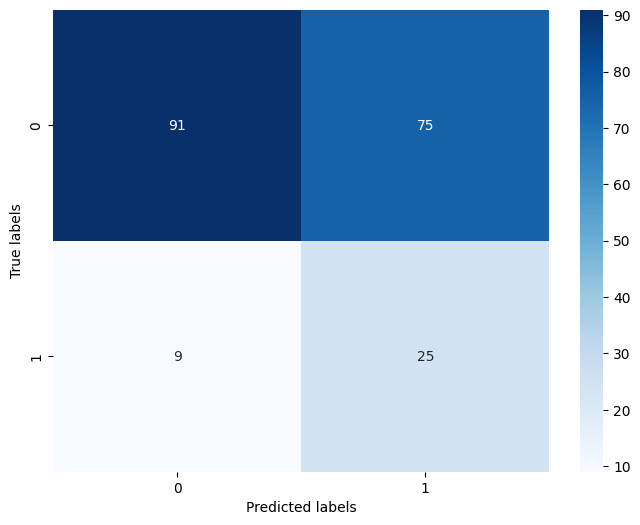

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
val_path = './pics_no_yse/val'
ploting(valid_loader, model,val_path)

Predicted class: 0
Predicted scores: tensor([[0.8360, 0.1640]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Gradients computed


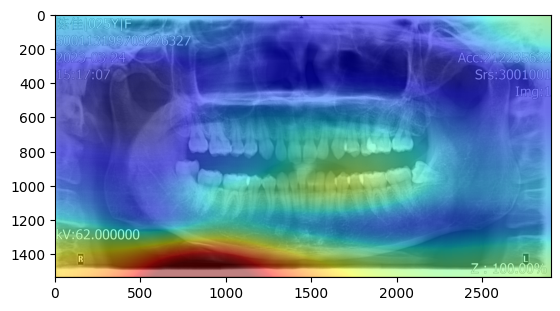

In [24]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 加载预训练的 VGG16 模型
pthfile = './vgg16_2/Model_epoch%32.pth'
model = torch.load(pthfile)
device = 'cuda'
model.to(device)
model.eval()

# 准备输入图像的变换
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载图像并应用变换
img_path = './pics_no_yse/val/0/chenjia_94.jpg'
img = Image.open(img_path).convert('RGB')
img_tensor = preprocess(img).unsqueeze(0).to(device)

# 确保输入图像的梯度被计算
img_tensor.requires_grad = True

# 获取最后一个卷积层的输出
def hook_feature(module, input, output):
    global feature
    feature = output
    feature.retain_grad()  # 保留 feature 张量的梯度


# 注册钩子
hook = model.features[-3].register_forward_hook(hook_feature)

# 前向传播
output = model(img_tensor)

# 获取预测分数和类别
pred_scores = F.softmax(output, dim=1)
pred_class = pred_scores.argmax(dim=1).item()

print(f"Predicted class: {pred_class}")
print(f"Predicted scores: {pred_scores}")

# 反向传播获取梯度
model.zero_grad()
one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=output.device)
one_hot_output[0][pred_class] = 2
output.backward(gradient=one_hot_output, retain_graph=True)

# 检查特征图是否正确计算了梯度
if feature is None:
    print("Feature is None. Ensure hook function is correctly set.")
elif feature.grad is None:
    print("Feature gradients are None. Ensure backward pass is done correctly.")
else:
    gradients = feature.grad[0]
    print("Gradients computed")

    # 计算权重
    weights = torch.mean(gradients, dim=[1, 2], keepdim=True)
    cam = torch.sum(weights * feature[0], dim=0)

    # 将 CAM 标准化
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    # 将 CAM 调整到输入图像的尺寸
    cam = cam.detach().cpu().numpy()
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(img.size, Image.LANCZOS)
    cam = np.array(cam)

    # 可视化热力图
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(cam, cmap='jet', alpha=0.5)
    plt.show()
